In [1]:
import os
import sys

module_path = os.path.join(os.getcwd(), '..', 'module')
sys.path.append(module_path)

from Data_preparation import data_for_clust
from Data_preparation import quantity_executors
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

In [3]:
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering

In [4]:
first_df = data_for_clust('../../data/Здания_Финальная_версия_ред.xlsx', 'Финальная ред')
clust_data = first_df[['ИНН исполнителя', 'Средняя цена контракта', 'Количество контрактов']]

clust_data = clust_data.copy()

clust_data = clust_data.loc[first_df['ИНН исполнителя'] != '']

clust_data['Средняя цена контракта log'] = np.log1p(clust_data['Средняя цена контракта'])
clust_data['Количество контрактов log'] = np.log1p(clust_data['Количество контрактов'])

clust_data_new = clust_data.drop(['Средняя цена контракта', 'ИНН исполнителя', 'Количество контрактов'], axis=1)

In [5]:
first_df

,ИНН исполнителя,Сумма контрактов,Средняя цена контракта,Максимальная цена контракта,Сумма оплат,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков
0,,13069388.48,1.306939e+07,13069388.48,13069388.48,1.306939e+07,1,NaN,NaN,NaN,0,0,0
1,1001146420,200000.00,2.000000e+05,200000.00,199990.25,1.999902e+05,1,3732000.0,3277000.0,455000.0,1,0,0
2,1001333318,280192.52,2.801925e+05,280192.52,246645.01,2.466450e+05,1,61659000.0,24491000.0,37168000.0,1,0,0
3,102002711630,786656.66,7.866567e+05,786656.66,786656.66,7.866567e+05,1,NaN,NaN,0.0,0,0,0
4,141701766795,204449.00,1.022245e+05,140000.00,74767.36,3.738368e+04,2,NaN,NaN,0.0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,7843302537,14000.00,1.400000e+04,14000.00,14000.00,1.400000e+04,1,NaN,NaN,0.0,0,0,0
385,7843307888,331626.57,3.316266e+05,331626.57,331626.57,3.316266e+05,1,NaN,NaN,0.0,0,0,0
386,8610006030,2017459.58,4.034919e+05,475204.20,2017459.58,4.034919e+05,5,22056000.0,14090000.0,7966000.0,0,2,0
387,8610031653,1543683.74,1.543684e+06,1543683.74,1543683.74,1.543684e+06,1,1870000.0,1117000.0,753000.0,0,0,0


In [6]:
column_names = clust_data_new.columns
index_names = clust_data_new.index

scaler = MinMaxScaler()
clust_data_scaled = scaler.fit_transform(clust_data_new)

clust_data_scaled = pd.DataFrame(clust_data_scaled, 
                                columns=column_names,
                                index=index_names)


print(clust_data_scaled.head())

   Средняя цена контракта log  Количество контрактов log
1                    0.360826                   0.000000
2                    0.393099                   0.000000
3                    0.491914                   0.000000
4                    0.296583                   0.100287
5                    0.392002                   0.100287


In [7]:
clust_data_scaled.head()

,Средняя цена контракта log,Количество контрактов log
1,0.360826,0.000000
2,0.393099,0.000000
3,0.491914,0.000000
4,0.296583,0.100287
5,0.392002,0.100287


In [8]:
clust_data_scaled.describe()

,Средняя цена контракта log,Количество контрактов log
count,388.000000,388.000000
mean,0.441862,0.069337
std,0.200048,0.136774
min,0.000000,0.000000
25%,0.306039,0.000000
50%,0.417068,0.000000
75%,0.574420,0.100287
max,1.000000,1.000000


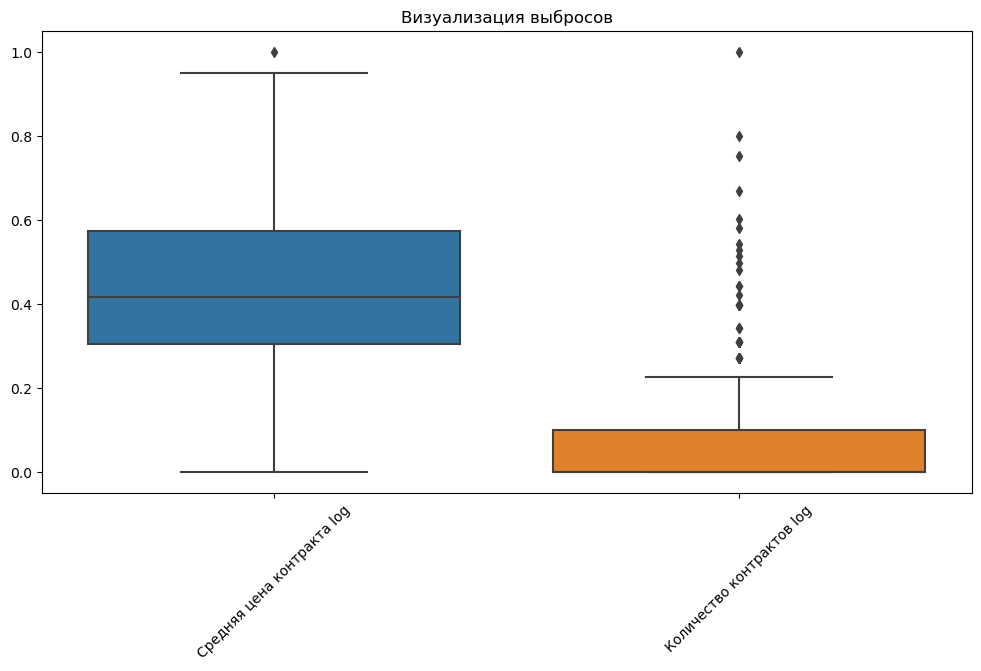

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=clust_data_scaled)
plt.xticks(rotation=45)
plt.title('Визуализация выбросов')
plt.show()

C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL

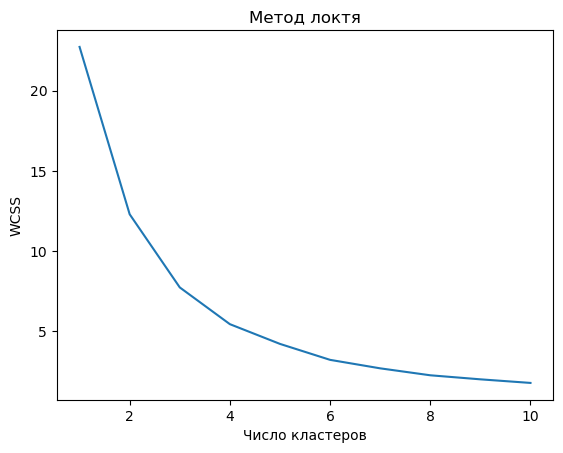

In [10]:
X = clust_data_scaled
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Метод локтя')
plt.xlabel('Число кластеров')
plt.ylabel('WCSS')
plt.show()

In [11]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [12]:
clust_data_scaled.columns.tolist()

['Средняя цена контракта log', 'Количество контрактов log']

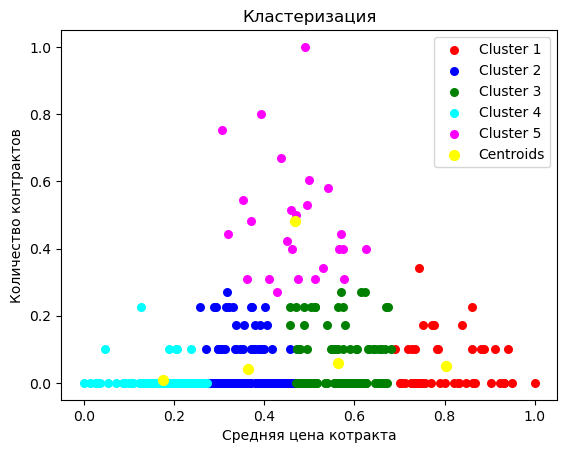

Центроиды кластеров:
   Средняя цена контракта log  Количество контрактов log  Кластер
0                    0.803768                   0.050180        0
1                    0.364621                   0.040451        1
2                    0.564043                   0.059757        2
3                    0.175711                   0.009708        3
4                    0.466966                   0.481620        4


In [13]:
X_array = X.values

plt.scatter(X_array[y_kmeans == 0, 0], X_array[y_kmeans == 0, 1], s=30, c='red', label='Cluster 1')
plt.scatter(X_array[y_kmeans == 1, 0], X_array[y_kmeans == 1, 1], s=30, c='blue', label='Cluster 2')
plt.scatter(X_array[y_kmeans == 2, 0], X_array[y_kmeans == 2, 1], s=30, c='green', label='Cluster 3')
plt.scatter(X_array[y_kmeans == 3, 0], X_array[y_kmeans == 3, 1], s=30, c='cyan', label='Cluster 4')
plt.scatter(X_array[y_kmeans == 4, 0], X_array[y_kmeans == 4, 1], s=30, c='magenta', label='Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='yellow', label='Centroids')
plt.title('Кластеризация')
plt.xlabel('Средняя цена котракта')
plt.ylabel('Количество контрактов')
plt.legend()
plt.show()

centroids = kmeans.cluster_centers_

centroids_df = pd.DataFrame(centroids, columns=clust_data_scaled.columns.tolist())
centroids_df['Кластер'] = range(len(centroids))

print("Центроиды кластеров:")
print(centroids_df)

In [14]:
clustered_data = X.copy()
clustered_data['Cluster'] = y_kmeans
clustered_data.head()

,Средняя цена контракта log,Количество контрактов log,Cluster
1,0.360826,0.000000,1
2,0.393099,0.000000,1
3,0.491914,0.000000,2
4,0.296583,0.100287,1
5,0.392002,0.100287,1


In [15]:
clustered_data = pd.concat([clust_data['ИНН исполнителя'].reset_index(drop=True), clustered_data.reset_index(drop=True)], axis=1)

In [16]:
clustered_data.head()

,ИНН исполнителя,Средняя цена контракта log,Количество контрактов log,Cluster
0,1001146420,0.360826,0.000000,1
1,1001333318,0.393099,0.000000,1
2,102002711630,0.491914,0.000000,2
3,141701766795,0.296583,0.100287,1
4,2100009963,0.392002,0.100287,1


In [17]:
data_with_clust = clust_data.copy()
data_with_clust['Cluster'] = y_kmeans
data_with_clust = data_with_clust.drop(['Средняя цена контракта log', 'Количество контрактов log'], axis = 1).round(2)
data_with_clust.head()

,ИНН исполнителя,Средняя цена контракта,Количество контрактов,Cluster
1,1001146420,200000.00,1,1
2,1001333318,280192.52,1,1
3,102002711630,786656.66,1,2
4,141701766795,102224.50,2,1
5,2100009963,277000.00,2,1


In [18]:
result = data_with_clust.groupby('Cluster').agg({
    'Средняя цена контракта': 'mean',
    'Количество контрактов': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'count'}).round(2)
result.head()

,Средняя цена контракта,Количество контрактов,count
Cluster,,,
0,30053536.71,1.60,47
1,240195.74,1.48,136
2,2075418.14,1.71,105
3,35837.09,1.11,75
4,862361.59,18.40,25


In [19]:
dbscan = DBSCAN(eps=0.09, min_samples=2)
clusters = dbscan.fit_predict(clust_data_scaled)

In [20]:
clusters

array([ 0,  0,  0,  1,  1,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,
        1,  0,  0,  0,  0,  1,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,
        1, -1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  1,  0,  0,
        0,  0,  1,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,
        0,  1,  0,  1,  0,  0,  0,  1,  1,  1,  0,  0,  1,  1,  1,  0,  1,
        0,  0,  1,  0,  0,  1,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  1,
        1,  1,  0,  1,  0,  0,  0,  0,  0,  1,  1,  1,  1,  0,  0,  1,  1,
        1,  0,  1,  1,  0,  1,  0,  1,  0,  0,  0,  0,  1,  1,  1,  0,  0,
        1,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1, -1,
        0,  1, -1,  1,  1,  1,  1, -1,  1,  1,  0,  0,  0,  1,  0,  0,  1,
        0,  0,  0, -1,  0,  1,  0,  0,  0,  1,  1,  2,  0,  0,  0,  1,  0,
        0,  1,  0,  1,  0

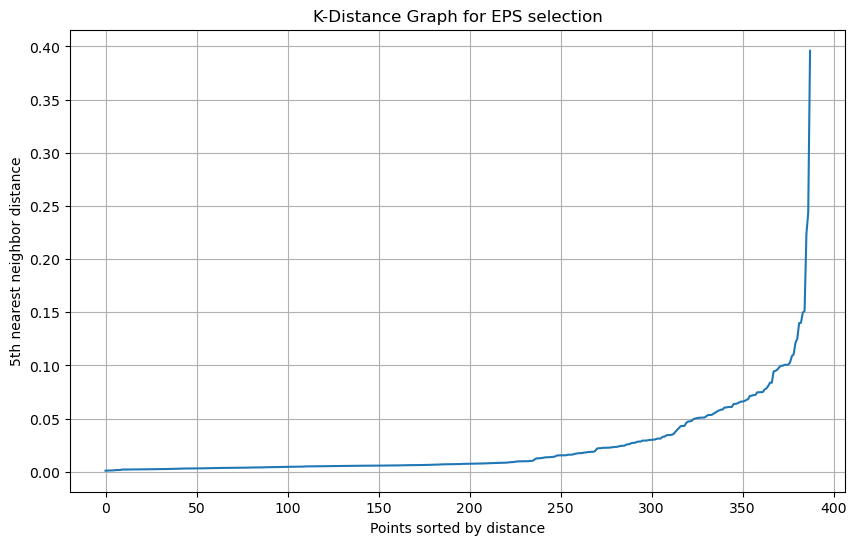

In [21]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(clust_data_scaled)
distances, indices = neighbors_fit.kneighbors(clust_data_scaled)

distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('5th nearest neighbor distance')
plt.title('K-Distance Graph for EPS selection')
plt.grid(True)

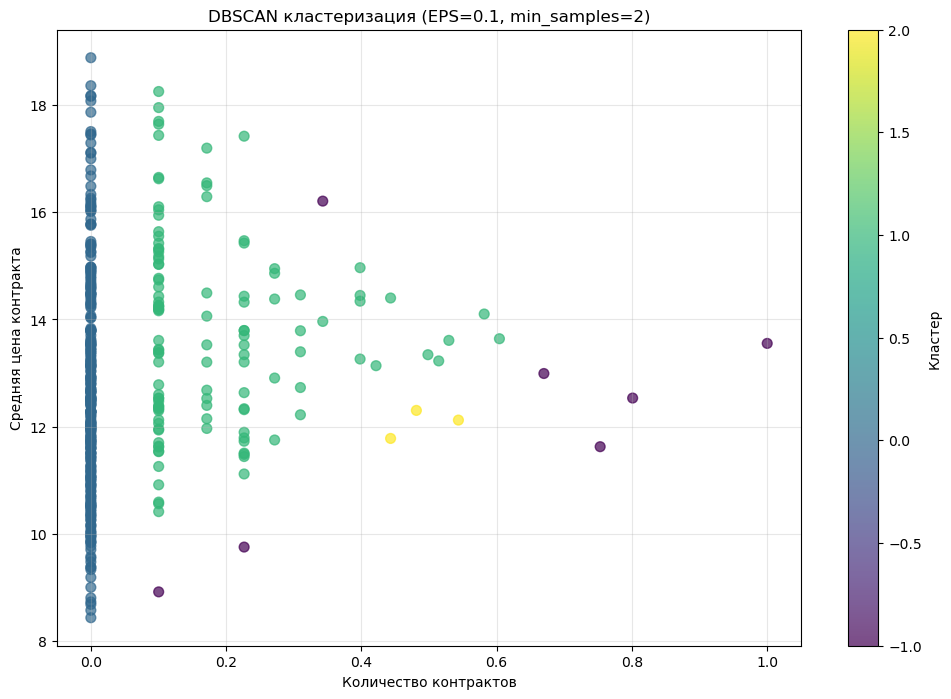

In [22]:

plt.figure(figsize=(12, 8))
scatter = plt.scatter(clust_data_scaled['Количество контрактов log'], clust_data['Средняя цена контракта log'], 
                     c=clusters, cmap='viridis', alpha=0.7, s=50)
plt.colorbar(scatter, label='Кластер')
plt.xlabel('Количество контрактов')
plt.ylabel('Средняя цена контракта')
plt.title('DBSCAN кластеризация (EPS=0.1, min_samples=2)')
plt.grid(True, alpha=0.3)

In [23]:
clust_data_scaled.head()

,Средняя цена контракта log,Количество контрактов log
1,0.360826,0.000000
2,0.393099,0.000000
3,0.491914,0.000000
4,0.296583,0.100287
5,0.392002,0.100287


In [24]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

hierarchical = AgglomerativeClustering(
    n_clusters=3,
    affinity='euclidean',
    linkage='ward'
)

data = hierarchical.fit_predict(clust_data_scaled)

C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [25]:
data

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0,
       2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1,
       2, 0, 1, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2,
       0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2,
       1, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 0, 2, 1, 2, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 2, 1, 2, 1, 0, 1, 0, 0, 0, 2, 2, 1, 1, 2, 0, 1, 1, 2, 2, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 0,
       2, 0, 2, 2, 0, 1, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 1, 1, 2, 0, 2, 1,
       0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 1, 0, 0, 0, 0, 2, 2, 0, 1, 0,
       2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 2, 2, 0, 2, 1, 1, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 1,
       0, 0, 1, 1, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1,

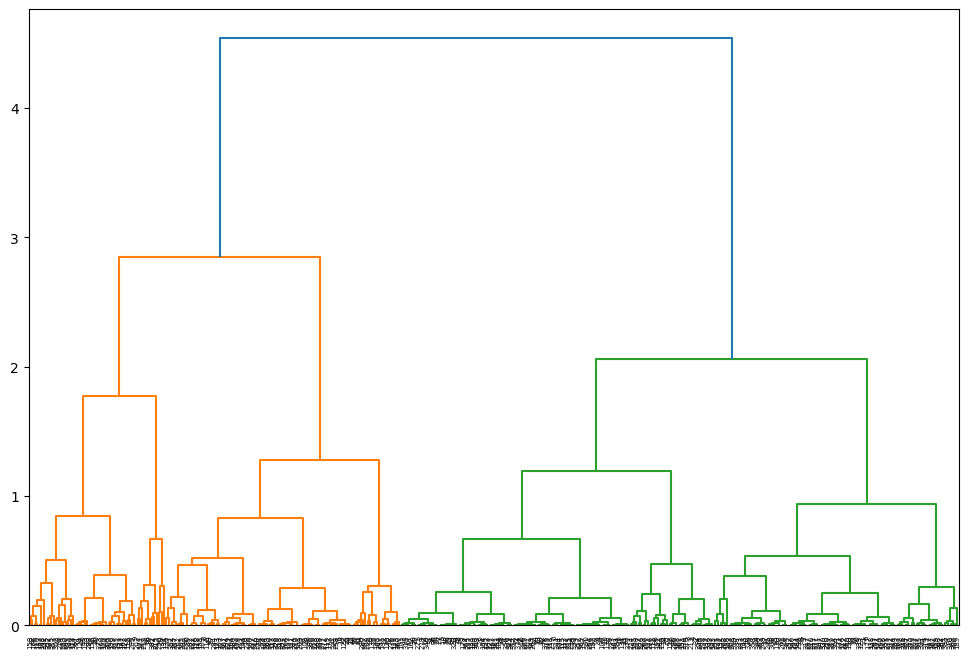

In [26]:
linked = linkage(clust_data_scaled, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           truncate_mode='level',
           )
plt.show()

In [27]:
clust_data_scaled.head()

,Средняя цена контракта log,Количество контрактов log
1,0.360826,0.000000
2,0.393099,0.000000
3,0.491914,0.000000
4,0.296583,0.100287
5,0.392002,0.100287


In [28]:
clust_data_scaled.to_excel('Здания для кластеризации.xlsx', index=False)

In [29]:
clust_data_ex = clust_data.copy()
clust_data_ex = clust_data_ex.drop(['Средняя цена контракта log', 'Количество контрактов log'], axis = 1)
clust_data_ex.head()

,ИНН исполнителя,Средняя цена контракта,Количество контрактов
1,1001146420,200000.00,1
2,1001333318,280192.52,1
3,102002711630,786656.66,1
4,141701766795,102224.50,2
5,2100009963,277000.00,2


In [30]:
clust_data_ex.to_excel('Здания для кластеризации 2.xlsx', index=False)

In [31]:
first_df[["ИНН исполнителя", "Средняя цена контракта", "Количество контрактов", "Прибыль(убыток)"]].to_excel('Здания для кластеризации 3.xlsx', index=False)

In [32]:
first_df

,ИНН исполнителя,Сумма контрактов,Средняя цена контракта,Максимальная цена контракта,Сумма оплат,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков
0,,13069388.48,1.306939e+07,13069388.48,13069388.48,1.306939e+07,1,NaN,NaN,NaN,0,0,0
1,1001146420,200000.00,2.000000e+05,200000.00,199990.25,1.999902e+05,1,3732000.0,3277000.0,455000.0,1,0,0
2,1001333318,280192.52,2.801925e+05,280192.52,246645.01,2.466450e+05,1,61659000.0,24491000.0,37168000.0,1,0,0
3,102002711630,786656.66,7.866567e+05,786656.66,786656.66,7.866567e+05,1,NaN,NaN,0.0,0,0,0
4,141701766795,204449.00,1.022245e+05,140000.00,74767.36,3.738368e+04,2,NaN,NaN,0.0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,7843302537,14000.00,1.400000e+04,14000.00,14000.00,1.400000e+04,1,NaN,NaN,0.0,0,0,0
385,7843307888,331626.57,3.316266e+05,331626.57,331626.57,3.316266e+05,1,NaN,NaN,0.0,0,0,0
386,8610006030,2017459.58,4.034919e+05,475204.20,2017459.58,4.034919e+05,5,22056000.0,14090000.0,7966000.0,0,2,0
387,8610031653,1543683.74,1.543684e+06,1543683.74,1543683.74,1.543684e+06,1,1870000.0,1117000.0,753000.0,0,0,0


In [33]:
similarity_df = first_df.drop(["Сумма контрактов", "Сумма оплат"], axis = 1)

In [34]:
similarity_df = similarity_df.drop(0)

In [35]:
similarity_df

,ИНН исполнителя,Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков
1,1001146420,200000.000,200000.00,199990.250,1,3732000.0,3277000.0,455000.0,1,0,0
2,1001333318,280192.520,280192.52,246645.010,1,61659000.0,24491000.0,37168000.0,1,0,0
3,102002711630,786656.660,786656.66,786656.660,1,NaN,NaN,0.0,0,0,0
4,141701766795,102224.500,140000.00,37383.680,2,NaN,NaN,0.0,2,0,1
5,2100009963,277000.000,438000.00,277000.000,2,1756000.0,729000.0,1027000.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
384,7843302537,14000.000,14000.00,14000.000,1,NaN,NaN,0.0,0,0,0
385,7843307888,331626.570,331626.57,331626.570,1,NaN,NaN,0.0,0,0,0
386,8610006030,403491.916,475204.20,403491.916,5,22056000.0,14090000.0,7966000.0,0,2,0
387,8610031653,1543683.740,1543683.74,1543683.740,1,1870000.0,1117000.0,753000.0,0,0,0


In [36]:
similarity_df.isna().sum().sum()

344

In [71]:
similarity = similarity_df.copy()

similarity['Рентабельность продаж'] = ((
    similarity['Прибыль(убыток)'] / similarity['Доходы']
    ).where(similarity['ИНН исполнителя'].astype(str).str.len() == 10))

similarity['Флаг цены'] = (
    (similarity['Максимальная цена контракта'] > 250_000_000 * 0.2)
    .astype(int)
)

similarity['Флаг контрактов'] = (
    (similarity['Количество контрактов'] > 1)
    .astype(int)
)

similarity['Флаг рентабельности'] = ((
    similarity['Прибыль(убыток)'] / similarity['Доходы']
    ).where(similarity['ИНН исполнителя'].astype(str).str.len() == 10) > 0.15).astype(int)
    

similarity['Флаг прекращенных контрактов'] = (
    (similarity['Количество прекращенных контрактов'] == 0)
    .astype(int)
)

similarity['Флаг штрафов'] = (
    (similarity['Неустойки (штрафы и пени)'] == 0)
    .astype(int)
)

similarity['Флаг реестра'] = (
    (similarity['Включение в реестр недобросовестных поставщиков'] == 0)
    .astype(int)
)

In [72]:
similarity.head()

,ИНН исполнителя,Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков,Рентабельность продаж,Флаг цены,Флаг контрактов,Флаг рентабельности,Флаг прекращенных контрактов,Флаг штрафов,Флаг реестра
1,1001146420,200000.00,200000.00,199990.25,1,3732000.0,3277000.0,455000.0,1,0,0,0.121919,0,0,0,0,1,1
2,1001333318,280192.52,280192.52,246645.01,1,61659000.0,24491000.0,37168000.0,1,0,0,0.602799,0,0,1,0,1,1
3,102002711630,786656.66,786656.66,786656.66,1,NaN,NaN,0.0,0,0,0,NaN,0,0,0,1,1,1
4,141701766795,102224.50,140000.00,37383.68,2,NaN,NaN,0.0,2,0,1,NaN,0,1,0,0,1,0
5,2100009963,277000.00,438000.00,277000.00,2,1756000.0,729000.0,1027000.0,0,0,0,0.584852,0,1,1,1,1,1


In [60]:
cols = ['Флаг цены', 'Флаг контрактов', 'Флаг рентабельности', 'Флаг прекращенных контрактов', 'Флаг штрафов', 'Флаг реестра']

weights = [0.2, 0.1, 0.15, 0.15, 0.1, 0.3]

In [61]:
similarity['Балл'] = sum(similarity[c] * w for c, w in zip(cols, weights))

In [62]:
similarity

,ИНН исполнителя,Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков,Флаг цены,Флаг контрактов,Флаг рентабельности,Флаг прекращенных контрактов,Флаг штрафов,Флаг реестра,Балл
1,1001146420,200000.000,200000.00,199990.250,1,3732000.0,3277000.0,455000.0,1,0,0,0,0,0,0,1,1,0.40
2,1001333318,280192.520,280192.52,246645.010,1,61659000.0,24491000.0,37168000.0,1,0,0,0,0,1,0,1,1,0.55
3,102002711630,786656.660,786656.66,786656.660,1,NaN,NaN,0.0,0,0,0,0,0,0,1,1,1,0.55
4,141701766795,102224.500,140000.00,37383.680,2,NaN,NaN,0.0,2,0,1,0,1,0,0,1,0,0.20
5,2100009963,277000.000,438000.00,277000.000,2,1756000.0,729000.0,1027000.0,0,0,0,0,1,1,1,1,1,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,7843302537,14000.000,14000.00,14000.000,1,NaN,NaN,0.0,0,0,0,0,0,0,1,1,1,0.55
385,7843307888,331626.570,331626.57,331626.570,1,NaN,NaN,0.0,0,0,0,0,0,0,1,1,1,0.55
386,8610006030,403491.916,475204.20,403491.916,5,22056000.0,14090000.0,7966000.0,0,2,0,0,1,1,1,0,1,0.70
387,8610031653,1543683.740,1543683.74,1543683.740,1,1870000.0,1117000.0,753000.0,0,0,0,0,0,1,1,1,1,0.70


In [63]:
similarity_sorted = similarity.sort_values(by='Балл', ascending=False)
similarity_sorted.head(20)

,ИНН исполнителя,Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков,Флаг цены,Флаг контрактов,Флаг рентабельности,Флаг прекращенных контрактов,Флаг штрафов,Флаг реестра,Балл
210,7813295730,6.264373e+07,9.797227e+07,6.264373e+07,2,5.012900e+07,3.956400e+07,1.056500e+07,0,0,0,1,1,1,1,1,1,1.00
140,7806438762,4.845000e+07,6.930000e+07,4.845000e+07,2,4.711500e+07,3.893400e+07,8.181000e+06,0,0,0,1,1,1,1,1,1,1.00
293,7839426699,1.588530e+08,1.588530e+08,1.588530e+08,1,2.012250e+08,1.671510e+08,3.407400e+07,0,0,0,1,0,1,1,1,1,0.90
100,7804455145,8.458728e+07,9.242786e+07,8.458228e+07,2,2.647680e+08,2.485090e+08,1.625900e+07,0,0,0,1,1,0,1,1,1,0.85
26,434593053826,4.597665e+07,6.660000e+07,4.597665e+07,2,NaN,NaN,0.000000e+00,0,0,0,1,1,0,1,1,1,0.85
184,7811079396,5.228757e+06,6.069889e+06,5.228757e+06,4,6.371000e+07,3.185600e+07,3.185400e+07,0,0,0,0,1,1,1,1,1,0.80
5,2100009963,2.770000e+05,4.380000e+05,2.770000e+05,2,1.756000e+06,7.290000e+05,1.027000e+06,0,0,0,0,1,1,1,1,1,0.80
215,7813537901,6.585165e+05,9.800000e+05,6.585165e+05,6,2.135150e+08,1.744130e+08,3.910200e+07,0,0,0,0,1,1,1,1,1,0.80
112,7804678913,1.319779e+05,2.134829e+05,1.319779e+05,4,1.965510e+10,1.507835e+10,4.576749e+09,0,0,0,0,1,1,1,1,1,0.80
223,7814327047,3.722822e+06,6.258343e+06,3.722822e+06,2,1.310300e+07,6.235000e+06,6.868000e+06,0,0,0,0,1,1,1,1,1,0.80


In [64]:
similarity_sorted.head(50)

,ИНН исполнителя,Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков,Флаг цены,Флаг контрактов,Флаг рентабельности,Флаг прекращенных контрактов,Флаг штрафов,Флаг реестра,Балл
210,7813295730,6.264373e+07,9.797227e+07,6.264373e+07,2,5.012900e+07,3.956400e+07,1.056500e+07,0,0,0,1,1,1,1,1,1,1.00
140,7806438762,4.845000e+07,6.930000e+07,4.845000e+07,2,4.711500e+07,3.893400e+07,8.181000e+06,0,0,0,1,1,1,1,1,1,1.00
293,7839426699,1.588530e+08,1.588530e+08,1.588530e+08,1,2.012250e+08,1.671510e+08,3.407400e+07,0,0,0,1,0,1,1,1,1,0.90
100,7804455145,8.458728e+07,9.242786e+07,8.458228e+07,2,2.647680e+08,2.485090e+08,1.625900e+07,0,0,0,1,1,0,1,1,1,0.85
26,434593053826,4.597665e+07,6.660000e+07,4.597665e+07,2,NaN,NaN,0.000000e+00,0,0,0,1,1,0,1,1,1,0.85
184,7811079396,5.228757e+06,6.069889e+06,5.228757e+06,4,6.371000e+07,3.185600e+07,3.185400e+07,0,0,0,0,1,1,1,1,1,0.80
5,2100009963,2.770000e+05,4.380000e+05,2.770000e+05,2,1.756000e+06,7.290000e+05,1.027000e+06,0,0,0,0,1,1,1,1,1,0.80
215,7813537901,6.585165e+05,9.800000e+05,6.585165e+05,6,2.135150e+08,1.744130e+08,3.910200e+07,0,0,0,0,1,1,1,1,1,0.80
112,7804678913,1.319779e+05,2.134829e+05,1.319779e+05,4,1.965510e+10,1.507835e+10,4.576749e+09,0,0,0,0,1,1,1,1,1,0.80
223,7814327047,3.722822e+06,6.258343e+06,3.722822e+06,2,1.310300e+07,6.235000e+06,6.868000e+06,0,0,0,0,1,1,1,1,1,0.80
